# Tehtävä 3-1

In [1]:
# Kirjoita tähän tietosi!
student_name = 'Iina Pirinen'  # Oma nimesi
student_id = 'AB7766' # Oma opiskelijatunnuksesi JAMK:ssa


### Aihe: Keras Functional API:n käyttö (2 p)

1. Luo alla olevan kuvan mukainen neuroverkko, jossa on useampi sisääntulo.
    * Kerroksien neuronien määrällä tai aktivointifunktiolla ei ole väliä, määritä ne itse vapaasti.
2. Aja "Tehtävän vastaukset" solu

Vinkkejä:
* Käytä `Concatenate`-kerrosta yhdistääksesi `Input2`- ja kolmas `Dense`-kerros vasemmalla kuvassa näkyvän Dense-kerroksen sisääntuloksi.
* Samoin käytä `Concatenate`-kerrosta yhdistääksesi `Input3`- ja kolmas `Dense`-kerros oikealla kuvassa näkyvän `Dense`-kerroksen sisääntuloksi.

* Vinkki: `Add`-kerroksen dokumentaatio: https://www.tensorflow.org/api_docs/python/tf/keras/layers/add?hl=th
Vinkki - koodihahmotelmaa mallin luomiseksi:
```
```

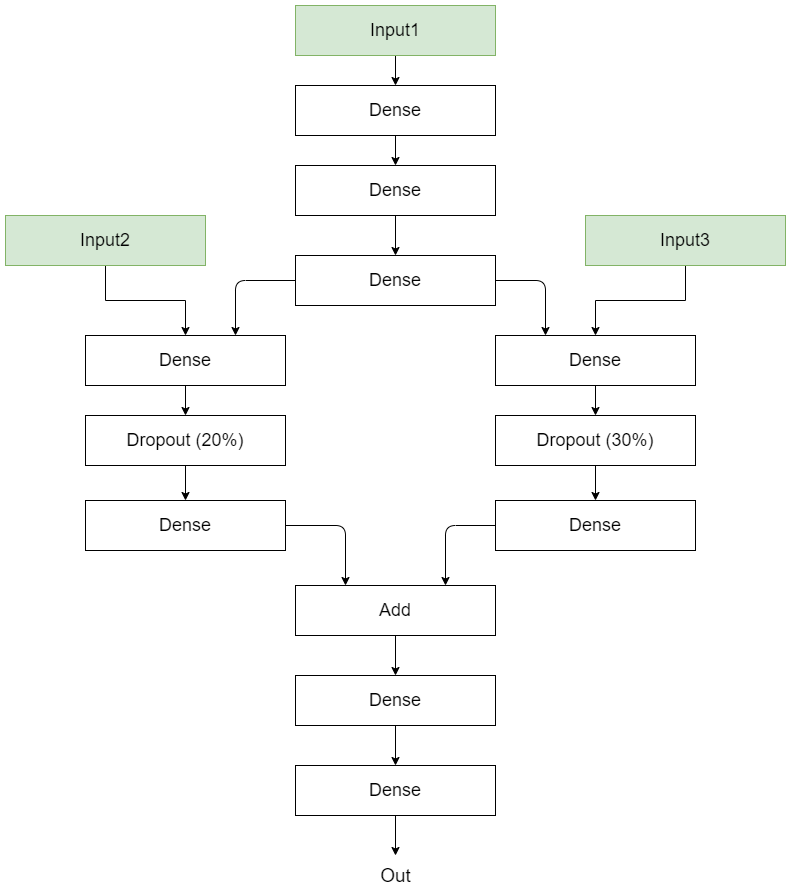

In [2]:
from IPython.display import Image
Image('../img/keras_functional_tehtava.png')

1. Input kerrokset

    Luodaan kolme syöttökerrosta, joista jokainen odottaa syötedataa, jonka muoto on (10,). Näitä käytetään kolmen eri syöttödatasarjan välittämiseen malliin.

2. Middle Dense Layers

    Kolme Dense kerrosta on yhdistetty peräkkäin. Jokaisessa kerroksessa on 8 yksikköä ja se käyttää oletuksena lineaarista aktivointitoimintoa.

3. Vasen haara

    input2:sta ketjutetaan viimeisen keskimmäisen Dense kerroksen lähtöön. Tämä ketjutettu tensori johdetaan sitten kahden muun Dense kerroksen läpi, joissa kummassakin on 8 yksikköä. Kahden Dense kerroksen väliin tulee pudotuskerros, jonka pudotusaste on 0,20.

4. Oikea haara
    
    Vasemman haaran tapaan input3:n tulo ketjutetaan viimeisen keskimmäisen Dense kerroksen lähtöön. Yhdistetty tensori johdetaan sitten kahden Dense kerroksen läpi, joissa kummassakin on 8 yksikköä. Kahden Dense kerroksen väliin tulee pudotuskerros, jonka pudotusaste on 0,30.

5. Vasemman ja oikean haaran yhdistäminen

    Vasemman ja oikean haaran viimeisten Dense kerrosten lähdöt lisätään elementtikohtaisesti.

6. Viimeiset Dense kerrokset

    Lisäyksestä saatuun summaan levitetään kaksi Dense lisäkerrosta. Lopullisessa tulostekerroksessa on 8 yksikköä.
    
7. Mallin kokoaminen

    Lopuksi luodaan Keras-malli määrittämällä tulot ja lähdöt.

In [3]:
# Tehtävän toteutus
import tensorflow as tf

# Input kerrokset
input1, input2, input3 = tf.keras.Input(shape=(4,)), tf.keras.Input(shape=(4,)), tf.keras.Input(shape=(4,))

# Keskimmäinen syöte
middle_dense1 = tf.keras.layers.Dense(6)(input1)
middle_dense2 = tf.keras.layers.Dense(6)(middle_dense1)
middle_dense3 = tf.keras.layers.Dense(6)(middle_dense2)

# vasen haara
left_concat = tf.keras.layers.concatenate([input2, middle_dense3])
left_dense1 = tf.keras.layers.Dense(6)(left_concat)
left_dropout = tf.keras.layers.Dropout(0.20)(left_dense1)
left_dense2 = tf.keras.layers.Dense(6)(left_dropout)

# oikea haara
right_concat = tf.keras.layers.concatenate([input3, middle_dense3])
right_dense1 = tf.keras.layers.Dense(6)(right_concat)
right_dropout = tf.keras.layers.Dropout(0.30)(right_dense1)
right_dense2 = tf.keras.layers.Dense(6)(right_dropout)

# yhdistetään vasen ja oikea haara Add-kerrokseen
add = tf.keras.layers.add([left_dense2, right_dense2])

# viimeiset Dense kerrokset
middle_dense4 = tf.keras.layers.Dense(8)(add)
out = tf.keras.layers.Dense(6)(middle_dense4)

# Sijoita luomasi malli model_functional - muuttujaan.
model_functional = tf.keras.Model(inputs=[input1, input2, input3], outputs=out)

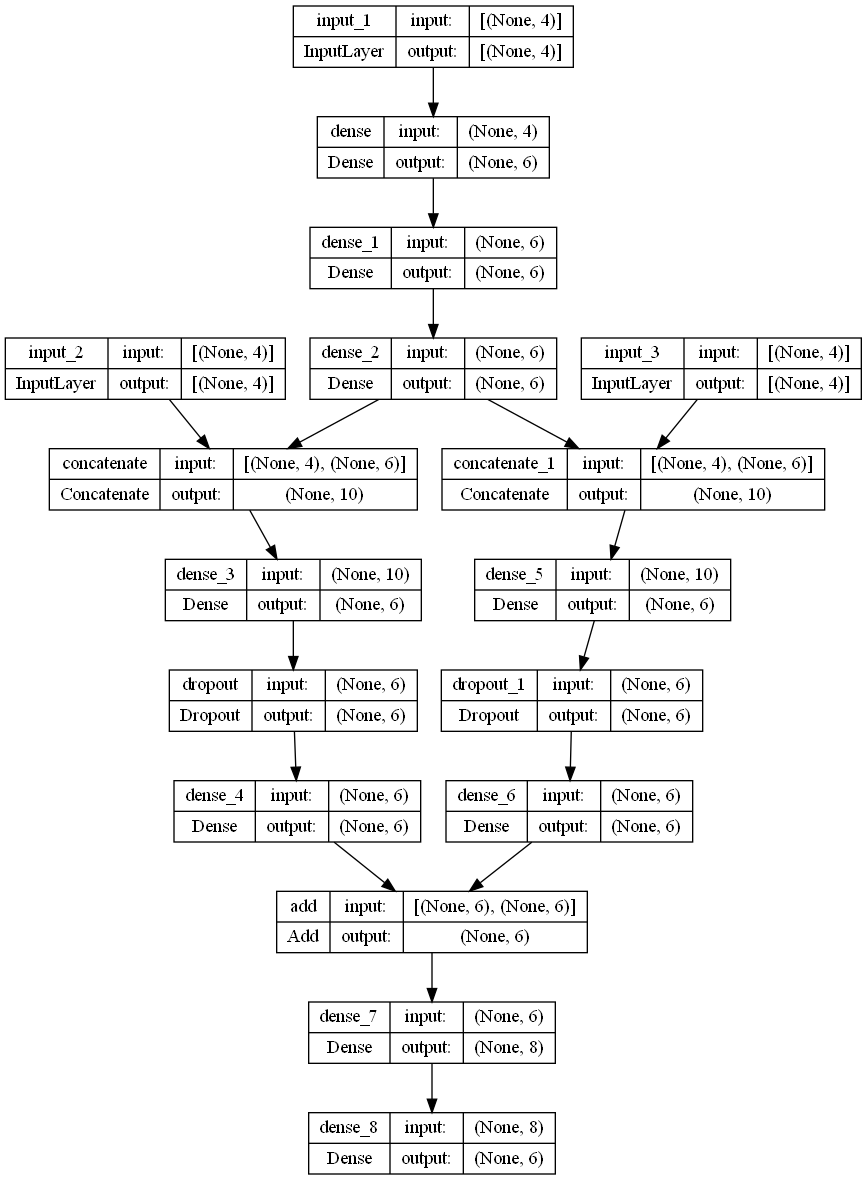

In [4]:
from tensorflow.keras.utils import plot_model

plot_model(model_functional, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. Sijoita luomasi malli model_functional - muuttujaan.

from IPython.display import SVG

# Piirretään kuva suoraan Notebook-dokumenttiin SVG-luokalla
svg = tf.keras.utils.model_to_dot(model_functional, dpi=70, show_shapes=True, expand_nested=True)
svg_img = SVG(svg.create(prog='dot', format='svg'))

In [6]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. Sijoita luomasi malli model_functional - muuttujaan.
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 6)            30          ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 6)            42          ['dense[0][0]']                  
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                              

Mallin Dense kerroksissa ei nyt määritellä aktivointifunktiota, mikä tarkoittaa, että ne käyttävät oletusarvoista aktivointifunktiota, joka on lineaarista aktivointia (a(x) = x).

Koska kyseessä oli harjoitella vain rakentamaan kuvan mukaista mallia, niin tässä en siis lähtenyt aktivointifunktiota määrittämään. Useimmissa luokitustehtävissä ja monimutkaisemmissa malleissa aktivointifunktioiden käyttöönotto on kuitenkin yleistä. Esimerkiksi:

- Regressio: Lineaarinen aktivointi (oletus) tai ei aktivointia.
- Binääriluokitus: Sigmoidiaktivointi (activation='sigmoid').
- Moniluokkaluokitus (Multiclass Classification): Softmax-aktivointi (activation='softmax').
- Piilotetut tasot (Hidden Layers): Piilotettujen tasojen yleisiä aktivointitoimintoja ovat Rectified Linear Unit (ReLU) (activation='relu'), hyperbolinen tangentti (tanh) (activation='tanh') tai muut muunnelmat.

# Tehtävä 3-2
### Aihe: Konvoluutioneuroverkko ja feature - matriisit (4 pistettä)

**Taustaa**

Conv2D-tasot muuttavat syöttökuvan matemaattikseki malliksi, jota tiiviisti kytketyt kerrokset käyttävät luokituksen (classification) luomiseen. Koska Dense-kerrokset voivat käsitellä vain 1D-dataa, ensin on muutettava viimeisen Conv2D-kerroksen antama moniulotteinen feature map 1D-muotoon Flatten-kerroksen avulla.

**Mallin konfigurointia** varten tarvitaan seuraavat tiedot:

* batch size arvoksi 50. Mallille syötetään 50 näytettä jokaisella askeleella.
* Kuvat ovat 32×32 pikselin kokoisia RGB-kuvia, ja ne asetetaan arvoihin (32, 32, 3)
* Häviöfunktio (loss function) on `sparse_categorical_crossentropy` ja `optimizer`-optimoija on `Adam()`
* Datassa olevia luokkia on 10.
* Epoch-kierrosten määrä on vain 5 iteraatiota. Reaalimäärässä kierroksia voi olla 50-100, mutta harjoitustehtävissä lisäkierroksista ei suuremmin ole hyötyä.
* Datasta 20% on testidataa. Loppu on opetusdataa.

**Syötedatan esikäsittely**:

* Muuta tiedot ennen neuroverkkoon sovittamista float32-formaattiin, minkä seurauksena koulutusprosessi on nopeampi GPU-prosessoinnissa.
* Tietojen skaalaaminen varmistaa, että painojen päivitykset ovat pienempiä, mikä parantaa lopputulostaa ja keventää datan prosessointia.

**Syväoppimismallin rakentaminen** (dokumentaatiota mukaillen):

When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers, does not include the sample axis). In the example inputs are 28x28 RGB images with `channels_last`:
>>> input_shape = (28, 28, 3)
>>> convLayer = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), activation='relu', input_shape=input_shape)

1. Tehtävässä määritetään kaksi `Conv2D`-kerrosta peräkkäisessä järjestyksessä (3×3 kernel size + ReLU-aktivointi) sekä niille suodatinmääriksi: 32 ja 64.
2. Seuraavaksi käytämme `Flatten`-kerrosta muuntamaan datan yksiulotteiseen muotoon.
3. Luokituksen luomiseen on kaksi `Dense`-kerrosta (suodatinten määrä 64 ja 10). Viimeinen kerros ei aktivoidu ReLU:lla, vaan Softmaxilla, jolloin saadaan moniluokkainen todennäköisyysjakauma vastauksena kysymykseen "mikä luokka on todennäköisin?".

**Mallin kokoaminen ja sovittaminen**
Syväoppimisen arkkitehtuurin tai kehyksen määrittelyn jälkeen voimme koota mallin ja sovittaa tiedot (eli aloittaa harjoittelun).

* Käännä malli
* sovita (*fit*) data malliin (`model.compile, model.fit`)
* arvioi mallin tulokset (`model.evaluate`) käyttäen erillistä testidataa.

**Arvioidaan ja tulostetaan:**
```
Test loss: ??? and Test accuracy: ???
```

In [7]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# Ladataan CIFAR-10 data
(X_train, y_train), (X_test, y_test)=  cifar10.load_data()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [8]:
# Skaalataan data parsimisen jälkeen
X_train = (X_train.astype('float32')) / 255.0
X_test = (X_test.astype('float32')) / 255.0

def create_and_compile_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding='same', activation="relu", input_shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


model = create_and_compile_model()

model.fit(X_train, y_train, epochs=5, batch_size=50)

Epoch 1/5
1000/1000 [==============================] - 23s 22ms/step - loss: 1.5166 - accuracy: 0.4527
Epoch 2/5
1000/1000 [==============================] - 22s 22ms/step - loss: 1.1638 - accuracy: 0.5857
Epoch 3/5
1000/1000 [==============================] - 22s 22ms/step - loss: 1.0063 - accuracy: 0.6408
Epoch 4/5
1000/1000 [==============================] - 22s 22ms/step - loss: 0.8918 - accuracy: 0.6822
Epoch 5/5
1000/1000 [==============================] - 30s 30ms/step - loss: 0.7924 - accuracy: 0.7172


In [9]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. 

# Tulostetaan  yhteenveto mallista sekä arviointimetriikka - poista kommentit ao. lauseista
model.summary()
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss: {score[0]} and accuracy: {score[1]}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                1048640   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                650       
                                                                 
Total params: 1,068,682
Trainable params: 1,068,682
Non-

Harjoitusdatalla päästiin aluksi lähes 90 % tarkkuuteen, mutta testidatalla tulokset jäivät paljon pienemmiksi. Lisäämällä dropout kerros, saatiin harjoitus ja testidatan tarkkuudet lähemmäksi toisiaan, eli enää ei tapahtu suurta ylisovittamista. Testidatalla tarkkuus parani lopulta kuitenkin vain 2% (noin 64 prosentista noin 66 prosenttiin).

# Tehtävä 3-3
## Aihe: Uutisotsikoiden luokittelu RNN-mallin avulla (4 p)

Tässä luokitellaan dataa sillä perusteella, että onko kyseessä ns. klikkiotsikko vai ei.

Tehtävässä käytetään seuraavaa dataa:
[https://github.com/bhargaviparanjape/clickbait/tree/master/dataset](https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

### Perusalgoritmi tehtävän toteuttamiseen

1. Lataa aineisto **clickbait_data.txt** ja **non_clickbait_data.txt**-tiedostoista
2. Leimataan otsikot luokkaan (on klikkiotsikko  == 1 tai ei ole klikkiotsikko == 0)
2. Jaetaan data koulutus- ja testidataan (75% koulutusdataa ja 25% testidataa jako)
4. Luo RNN-malli, joka ennustaa, onko otsikko klikkiotsikko (clickbait) vai eikö se ole
5. Ennusta mallin tarkkuus `evaluate` - funktiolla

### Vinkkejä:
* Käytä numeeriseen muunnokseen `tf.keras.preprocessing.text.Tokenizer` - luokkaa
* Luo otsikoista samanpituiset sekvenssit: (`num_words=sanojen_määrä`)

### RNN ja LSTM

Recurrent neural networks (RNN) sopivat erityisen hyvin peräkkäisille tiedoille. Tunnettuja käytännön sovelluksia ovat mm. Googlen puhehaku ja Applen Siri.

* RNN sisältää sisäisen muistin.
* RNN on syväoppimisalgoritmi, joka voi muistaa syötteen.
* RNN:n sovelluksia ovat **LSTM** ja **GRU**
* RNN on suositeltu algoritmi peräkkäisille tiedoille, mm. kirjoitetulle tekstille, aikasarjoille, sääennusteille, taloustiedoille jne.

RNN:ssä data kiertää sisäisessä silmukassa. Kun RNN laskee output-kerroksen, se huomioi myös edellisen kerroksen ja myös sitä edeltävän kerroksen, koska sillä on lyhytaikainen muisti.

#### Tehtävän voi tehdä kahdella eri tavalla
Pisteitä annettaessa riittää, että on kuitenkin tehnyt toisella ao. tavoista:
1. SimpleRNN
2. LSTM - Tämä on suositeltavampi tapa tässä tehtävässä.

In [16]:
# Kirjastot

import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [17]:
# Luetaan tiedostot dataframeen

def read_data(file_path):
    with open(file_path, encoding='utf-8') as file:
        lines = file.read().splitlines()
    return [header for header in lines if header]

def create_dataframe(headers, label):
    df = pd.DataFrame({'header': headers, 'clickbait': label})
    return df

clickbait = read_data('data/clickbait_data.txt')
non_clickbait = read_data('data/non_clickbait_data.txt')

otsikot_df = pd.concat([
    create_dataframe(clickbait, 1),
    create_dataframe(non_clickbait, 0)
], ignore_index=True)

In [18]:
otsikot_df

,header,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


### Datan jako ja esikäsittely mallille

Tässä vaiheessa jaetaan data koulutus- ja testidataksi. Lisätään myös validaatiodata X_val ja y_val. Tämä lisäys varmistaa, että malli on koulutettu harjoitusdatalla ja sen suorituskykyä seurataan validointidatalla harjoituksen aikana. Testidata pysyy koskemattomana, kunnes ollaan valmiita arvioimaan lopullista mallia harjoittelun jälkeen.

Muita huomioita:

- 'Tokenizer' on prosessi, jossa teksti muunnetaan merkkijonoksi, jossa jokainen merkki edustaa yleensä sanaa tai alisanaa.
- 'num_words'-parametri määrittää säilytettävien sanojen enimmäismäärän sanatiheyden perusteella. Tässä tapauksessa asetettu arvoon 20 000, mikä tarkoittaa, että tokenizer säilyttää 20 000 yleisintä sanaa tietojoukossa.
- 'fit_on_texts' -menetelmää käytetään sisäisen sanaston päivittämiseen tekstiluettelon perusteella. Tässä tapauksessa sovitetaan  tokenisaattori DataFrame-kehyksen (df) 'otsikko' -sarakkeeseen. Menetelmä ottaa syötteeksi otsikot ja päivittää tokenisaattorin sisäisen tilan rakentaakseen sanaston näistä teksteistä. Sanastoa käytetään sitten sanojen muuntamiseen numeerisiksi indekseiksi.
- Tokenisaattorin sovituksen jälkeen voidaan käyttää 'texts_to_sequences' -menetelmää tekstitiedon muuntamiseksi indeksisarjoiksi opitun sanaston perusteella.

In [19]:
# Muunnetaan teksti merkkijonoiksi
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(otsikot_df['header'].values)

# Jaetaan tiedot harjoitus- ja väliaikaisiin validointi + testi sarjoihin
X = otsikot_df['header'].values
y = otsikot_df['clickbait'].values
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Jaetaan väliaikainen joukko edelleen koulutus- ja validointisarjoiksi
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

# Muunnetaan tekstidata indeksisarjoiksi
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

# Pehmusta? (pad) sekvenssit, jotta ne ovat samanpituisia
X_train = pad_sequences(X_train, maxlen = 64)
X_test = pad_sequences(X_test, maxlen = 64)
X_val = pad_sequences(X_val, maxlen = 64)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_val.shape)
print(y_test.shape)
print(y_train.shape)

(18000, 64)
(8000, 64)
(6000, 64)
(6000,)
(8000,)
(18000,)


### Mallin luominen

Alla luodussa simppelissä mallissa on embedding kerros, jota seuraa LSTM-kerros ja Dense kerros. Embedding kerros on vastuussa kokonaislukuindeksien muuntamisesta tiheiksi vektoreiksi. LSTM-kerros käsittelee datasekvenssejä, ja Dense kerrosta, jossa on sigmoidiaktivointitoiminto, käytetään binääriluokitukseen.

1. Kerrokset

    - Embedding kerros: muuntaa kokonaislukuindeksit (esittävät sanoja) tiheiksi, kiinteän kokoisiksi vektoreiksi. Tulostusmuoto on (none, 64, 16), mikä osoittaa sekvenssin pituuden 64 ja upotusmitan 16.
    - LSTM-kerros: käsittelee upotuskerroksen peräkkäistä syötettä ja siinä on 100 yksikköä. Tulosteen muoto on (none, 100).
    - Dense kerros: binääriluokituksen tulostekerros, jossa on 1 yksikkö ja sigmoidiaktivointitoiminto. Tulosteen muoto on (none, 1).
    
2. Parametrit

    - Embedding tason parametrit: 320 000 parametria, jossa 20 000 (sanaston koko) kerrottuna 16:lla (upotusulottuvuus) on 320 000.
    - LSTM-kerroksen parametrit: LSTM-tasolla on 46 800 parametria. Tarkka laskelma sisältää yksiköiden määrän, syöttöulottuvuuden ja erilaiset poikkeamat.
    - Dense kerroksen parametrit: 101 parametria. Sisältää painot ja painotukset.

3. Koulutettavat parametrit yhteensä: Mallissa on yhteensä 366 901 koulutettavaa parametria. Nämä ovat painoja ja painotuksia, joita malli säätää harjoituksen aikana menetyksen minimoimiseksi.

4. Ei-opetettavat parametrit: Tässä mallissa ei ole ei-opetettavia parametreja.

In [20]:
words_size = 20000
embedding_dim = 16

model = tf.keras.Sequential([
         Embedding(words_size, embedding_dim, input_length=64),
         LSTM(100),
         #Dropout()
         Dense(1, activation='sigmoid')
       ])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 16)            320000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               46800     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 366,901
Trainable params: 366,901
Non-trainable params: 0
_________________________________________________________________
None


model.fit-menetelmä palauttaa **History**-objektin (historiamuuttujan), joka sisältää tietoa koulutusprosessista. Tämä sisältää koulutus- ja validointihäviön sekä kaikki mallia laatiessa määritetyt lisätiedot (esim. tarkkuus).

In [21]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=64)

Epoch 1/3
282/282 [==============================] - 14s 40ms/step - loss: 0.2222 - accuracy: 0.9008 - val_loss: 0.0833 - val_accuracy: 0.9683
Epoch 2/3
282/282 [==============================] - 10s 37ms/step - loss: 0.0410 - accuracy: 0.9868 - val_loss: 0.0748 - val_accuracy: 0.9732
Epoch 3/3
282/282 [==============================] - 11s 37ms/step - loss: 0.0463 - accuracy: 0.9929 - val_loss: 0.0789 - val_accuracy: 0.9727


Sitten **model.evaluate**-menetelmää käytetään arvioimaan opetetun mallin suorituskykyä tässä tietojoukossa.

model.evaluate-menetelmä laskee häviön ja tarkkuuden. Menetelmä palauttaa luettelon arvoista, jotka edustavat arviointituloksia. Nämä tulokset tallennetaan **results** -muuttujaan.

In [22]:
results = model.evaluate(X_test, y_test, batch_size=64)

125/125 [==============================] - 2s 14ms/step - loss: 0.0737 - accuracy: 0.9762


In [23]:
# Tehtävän vastaukset. Huom! Älä muokkaa tätä solua, vaan aja se, kun olet suorittanut tehtävän. Sijoita results - muuttujaan funktion model.evaluate() tulos.

# Muista määrittää model.compile() - funktioon seurattavaksi suureeksi metrics=['accuracy'], jotta näät, kuinka suuri osa neuroverkon ennustuksista on oikein.
print(f"Test Loss:{results[0]} Test Accuracy:{results[1]*100}%")

Test Loss:0.07365269958972931 Test Accuracy:97.62499928474426%


### Analyysi

- Harjoittelutarkkuus kasvaa jatkuvasti epoch kierrosten aikana saavuttaen erittäin korkean arvon kolmannella epoch kierroksella (99,29 %). Tämä saattaisi viitata siihen, että malli oppii hyvin harjoitustiedoista.
- Validointitarkkuus myös kasvaa ja pysyy korkeana, mikä osoittaa hyvää yleistämistä ennen näkemättömään dataan.
- Myös testin tarkkuus on korkea (97,62 %), mikä on positiivinen merkki. Se osoittaa, että malli toimii hyvin datalla, jota se ei ole koskaan nähnyt, mikä vahvistaa sen kykyä yleistää.

#### Huomioita

- Malli näyttää toimivan hyvin sekä koulutus- että validointitiedoissa, eikä ole merkkejä ylisovittamisesta.
- Testin tarkkuus on lähellä validointitarkkuutta, mikä osoittaa sitä, että malli ei ylisovita validointijoukkoa.

Kaiken kaikkiaan tulosten perusteella näyttää siltä, että malli luokittelee tehokkaasti klikki- ja ei-klikkiotsikot ja saavuttaa suuren tarkkuuden sekä validointi- että testisarjoissa.

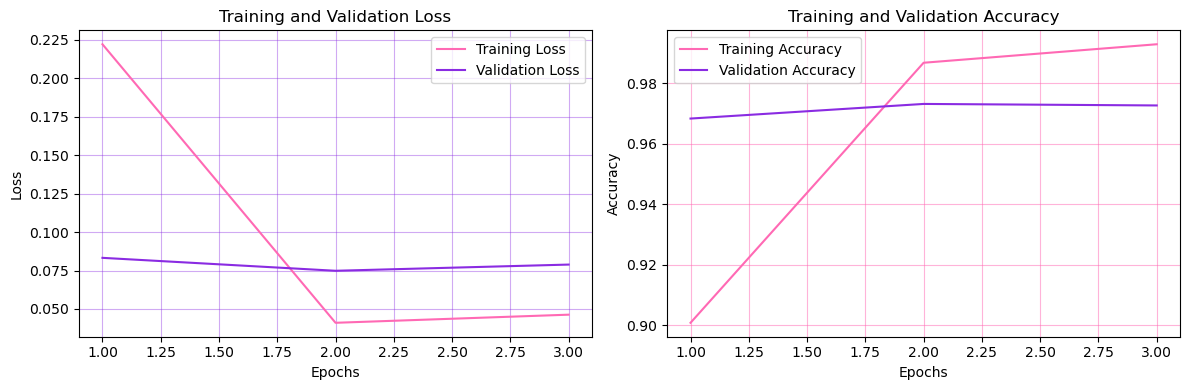

In [30]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Barbie-teemaiset värit
barbie_pink = '#FF69B4'  # Pinkki
barbie_purple = '#8A2BE2'  # Purppura

# Piirretään koulutus ja validointihäviö
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color=barbie_pink)
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color=barbie_purple)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(c=barbie_purple, alpha=0.4)
plt.legend()

# Piiretään koulutus ja validointitarkkuus
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', color=barbie_pink)
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color=barbie_purple)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(c=barbie_pink, alpha=0.5)

plt.tight_layout()
plt.show()


Häviökuvaajasta huomataan, että validaation sekä koulutuksen häviöt alkavat hieman kasvaa kun epoch kierroksien määrä on 2. Tarkkuuskuvaajasta nähdään, että validaation tarkkuus myös aivan minimaalisesti laskee kun epoch kierrokset ylittävät 2. Koulutksen tarkkuus kuitenkin nousee vielä kahden epoch kierroksen jälkeenkin.

Kun validointihäviö kasvaa ja validointitarkkuus laskee tietyn ajanjakson jälkeen, se osoittaa, että malli saattaa alkaa ylisovittaa opetusdataa. Ylisovitus tapahtuu, kun malli oppii harjoitusdatan liian hyvin, mukaan lukien sen kohinat ja erityispiirteet, mikä haittaa sen kykyä yleistää uuteen, näkemättömään dataan.

Tässä tapauksessa aikakausien määrän vähentäminen voisi olla hyvä tapa estää liiallinen sovitus. Jos validointihäviö ja tarkkuus alkavat tasaantua tai heikentyä tietyn ajanjakson jälkeen, useamman epoch kierroksen harjoittelu voi saada mallin muistamaan harjoitustiedot yleisten kuvoiden oppimisen sijaan.

Epoch kierrosten määrää voisi kokeilla vielä laskea kahteen ja seurata validoinnin suorituskykyä. On kuitenkin myös tärkeää löytää tasapaino. Jos vähennetään epoch kierrosten määrää liikaa, mallilla ei ehkä ole riittävästi koulutusaikaa lähentyäkseen ja oppiakseen tiedoista.